In [1]:
import xarray as xr
import numpy as np
import gsw
from dask.diagnostics import ProgressBar
import os.path as op
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ddir = '/mnt/meom/workdir/dewarw/eSM60-BLBT02-S/'
sdir = '/scratch/dewardom/'

In [3]:
g = 9.81
ys,ye = (198,402)
xs,xe = (1168,1372)

dsmask = xr.open_dataset(op.join(ddir,'../mask.nc'))
At = (dsmask.e1t * dsmask.e2t)[0].sel(y=slice(ys,ye),x=slice(xs,xe))
dsmask

<xarray.Dataset>
Dimensions:       (t: 1, x: 2170, y: 887, z: 300)
Dimensions without coordinates: t, x, y, z
Data variables:
    e3t_0         (t, z, y, x) float64 ...
    e3t_1d        (t, z) float64 ...
    e3u_0         (t, z, y, x) float64 ...
    e3v_0         (t, z, y, x) float64 ...
    e3w_0         (t, z, y, x) float64 ...
    e3w_1d        (t, z) float64 ...
    gdept_0       (t, z, y, x) float32 ...
    gdept_1d      (t, z) float64 ...
    gdepu         (t, z, y, x) float32 ...
    gdepv         (t, z, y, x) float32 ...
    gdepw_0       (t, z, y, x) float32 ...
    gdepw_1d      (t, z) float64 ...
    isfdraft      (t, y, x) float32 ...
    mbathy        (t, y, x) int16 ...
    misf          (t, y, x) int16 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    nav_lon       (y, x) float32 ...
    time_counter  (t) float64 ...
    fmask         (t, z, y, x) int8 ...
    fmaskutil     (t, y, x) int8 ...
    tmask         (t, z, y, x) int8 ...
    tma

In [4]:
cori = gsw.f(dsmask.nav_lat.sel(y=slice(ys+2,ye-2),x=slice(xs+2,xe-2)))
fb = ((cori*At[2:-2,2:-2]).coarsen({'y':5,'x':5}, boundary='trim').sum()
      / At[2:-2,2:-2].coarsen({'y':5,'x':5}, boundary='trim').sum()
     )

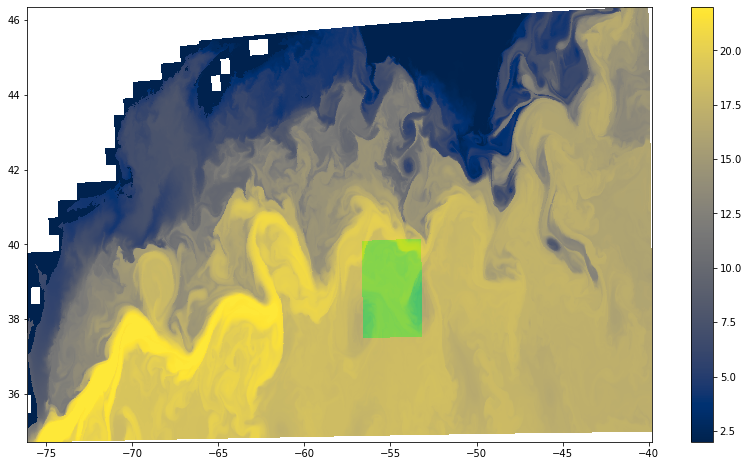

In [5]:
dst = xr.open_dataset(op.join(ddir,'eSM60-BLBT02_y2010m03d01.1h_gridT.nc'))
sst = dst.votemper[:,0].load()

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
im = ax.pcolor(dst.nav_lon.where(dst.nav_lon!=0.), 
              dst.nav_lat.where(dst.nav_lat!=0.), 
              sst[0],
              cmap='cividis', vmin=2, vmax=22)
ax.pcolor(dst.nav_lon.where(dst.nav_lon!=0.).sel(y=slice(ys,ye),x=slice(xs,xe)), 
         dst.nav_lat.where(dst.nav_lat!=0.).sel(y=slice(ys,ye),x=slice(xs,xe)), 
         sst.sel(y=slice(ys,ye),x=slice(xs,xe))[0],
         cmap='viridis', vmin=2, vmax=22)
cbar = fig.colorbar(im)

# March 2010

Let's look at the relation $\overline{w'b'}^{xy}(z)\propto\frac{H_\text{ML}^2|\nabla_\text{H}\overline{b}^{xyz}|}{f}\mu(z)$ using the patch above in eNATL60.

$\overline{w'b'}^{xy} \equiv \overline{(w-\overline{w}^{xy})(b-\overline{b}^{xy})}^{xy}$ where $\overline{(\cdot)}^{xy}$ is "naively" defined as the horizontal spatial average of $5\times 5$ grid boxes. (The eddy flux term can also be calculated using a Reynolds averaging $\overline{w'b'}^{xy} = \overline{wb}^{xy} - \overline{w}^{xy}\overline{b}^{xy}$.)

$\overline{b}^{xyz}$ is defined as first coarse graining the field by $5\times 5$ grid boxes and then taking the depth average over the mixed layer.

In [20]:
wpCpb = xr.open_mfdataset(op.join(sdir,'wpCpb-Reynolds_y2010m03d*.nc'), concat_dim='time')
gradC2H = xr.open_mfdataset(op.join(sdir,'gradCb2-H2_y2010m03d*.nc'), concat_dim='time')
wpCpb

/home/uchidat/.conda/envs/natl/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/uchidat/.conda/envs/natl/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,
/home/u

<xarray.Dataset>
Dimensions:       (depthw: 80, time: 744, x: 40, y: 40)
Coordinates:
  * depthw        (depthw) float32 1.0000261 2.156828 ... 579.2115 592.83234
    time_counter  (time) datetime64[ns] 2010-03-01T00:30:00 ... 2010-03-31T23:30:00
    deptht        (time, y, x) float32 dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
Dimensions without coordinates: time, x, y
Data variables:
    wpbpb         (time, depthw, y, x) float64 dask.array<chunksize=(1, 80, 40, 40), meta=np.ndarray>
    wptpb         (time, depthw, y, x) float64 dask.array<chunksize=(1, 80, 40, 40), meta=np.ndarray>
    wpspb         (time, depthw, y, x) float64 dask.array<chunksize=(1, 80, 40, 40), meta=np.ndarray>

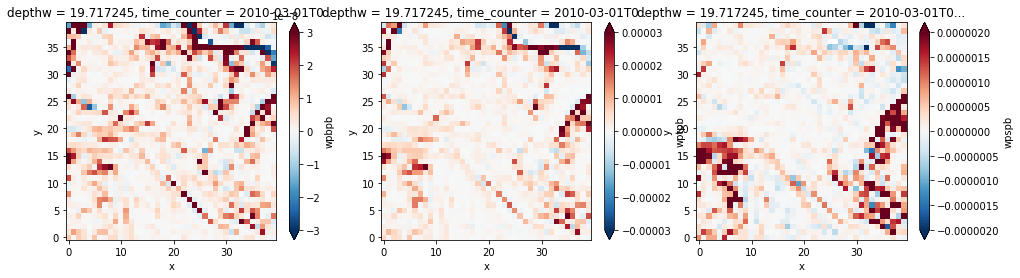

In [30]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(16,4))
# fig.set_tight_layout(True)
wpCpb.wpbpb[0,10].plot(ax=ax1, cmap='RdBu_r', vmax=3e-8)
wpCpb.wptpb[0,10].plot(ax=ax2, cmap='RdBu_r', vmax=3e-5)
wpCpb.wpspb[0,10].plot(ax=ax3, cmap='RdBu_r', vmax=2e-6)

Text(0, 0.5, "$\\overline{w's'}^{xy}$ ($\\times 10^{-5}$) [m (g/kg) s$^{-1}$]")

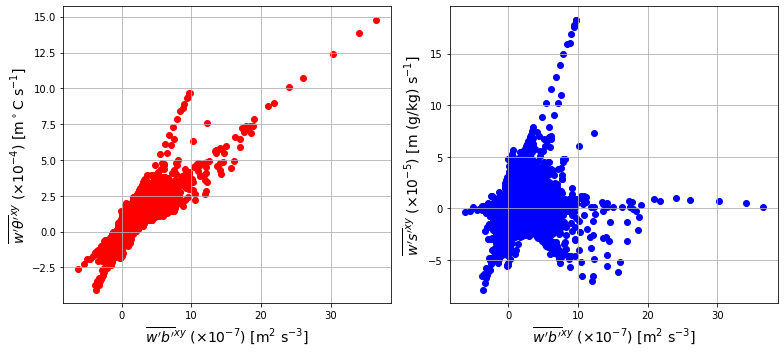

In [21]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
fig.set_tight_layout(True)
ax1.grid(True)
ax2.grid(True)
# ax3.grid(True)
ax1.scatter(wpCpb.wpbpb[::24,::2]*1e7, wpCpb.wptpb[::24,::2]*1e4, 
            c='r')
ax2.scatter(wpCpb.wpbpb[::24,::2]*1e7, wpCpb.wpspb[::24,::2]*1e5, 
            c='b')
# ax3.scatter(wpCpb.wpbpb[::24,::2]*1e7, wpbp_lin*1e7, 
#             c='k')
# ax1.set_xlim([-1e0,5e0])
# ax1.set_ylim([-1e0,4e0])
# ax2.set_xlim([-1e0,5e0])
# ax2.set_ylim([-2e0,4e0])
# ax3.set_xlim([-1e0,5e0])
# ax3.set_ylim([-4e0,3e0])
ax1.set_xlabel(r"$\overline{w'b'}^{xy}$ ($\times 10^{-7}$) [m$^2$ s$^{-3}$]", fontsize=14)
ax2.set_xlabel(r"$\overline{w'b'}^{xy}$ ($\times 10^{-7}$) [m$^2$ s$^{-3}$]", fontsize=14)
ax1.set_ylabel(r"$\overline{w'\theta'}^{xy}$ ($\times 10^{-4}$) [m$^\circ$C s$^{-1}$]", fontsize=14)
ax2.set_ylabel(r"$\overline{w's'}^{xy}$ ($\times 10^{-5}$) [m (g/kg) s$^{-1}$]", fontsize=14)
# ax3.set_xlabel(r"$\overline{w'b'}$ ($\times 10^{-7}$) [m$^2$ s$^{-3}$]", fontsize=14)
# ax3.set_ylabel(r"$g(\alpha\overline{w'\theta'}^{xy}-\beta\overline{w's'}^{xy})$ ($\times 10^{-7}$) [m$^2$ s$^{-3}$]", 
#                fontsize=14)

(1e-12, 1e-06)

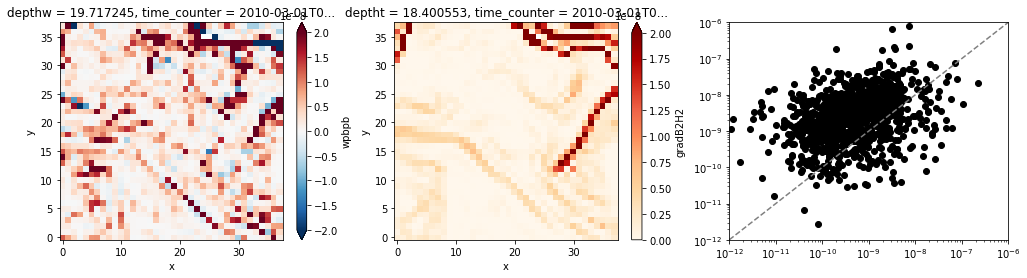

In [25]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,4))
(wpCpb.wpbpb[0,10,1:-1,1:-1]).plot(ax=ax1, vmax=2e-8)
(1e-2*gradC2H.gradB2H2[0,10]).plot(ax=ax2, vmin=0., vmax=2e-8, cmap='OrRd')
ax3.scatter(1e-2*gradC2H.gradB2H2[0,10], wpCpb.wpbpb[0,10,1:-1,1:-1], c='k')
ax3.plot(np.linspace(1e-12,1e-5), np.linspace(1e-12,1e-5), c='grey', ls='--')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim([1e-12,1e-6])
ax3.set_xlim([1e-12,1e-6])

Text(0.5, 0, '$H_{\\tt ML}^2|\\nabla_{\\tt H}\\overline{s}^{xyz}|^2 / f$ [(g/kg)$^2$ s]')

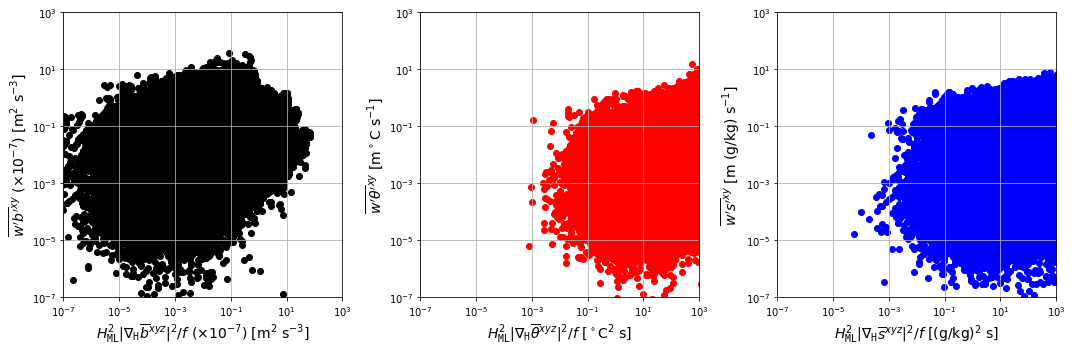

In [31]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
fig.set_tight_layout(True)
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax1.scatter(1e-2*gradC2H.gradB2H2[::24,1::2]*1e7,
            wpCpb.wpbpb[::24,::2,1:-1,1:-1]*1e7, 
            c='k')
ax2.scatter(1e-2*gradC2H.gradT2H2[::24,1::2]*1e4, 
            wpCpb.wptpb[::24,::2,1:-1,1:-1]*1e4,
            c='r')
ax3.scatter(1e-2*gradC2H.gradS2H2[::24,1::2]*1e5,
            wpCpb.wpspb[::24,::2,1:-1,1:-1]*1e5, 
            c='b')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax1.set_ylim([1e-7,1e3])
ax1.set_xlim([1e-7,1e3])
ax2.set_ylim([1e-7,1e3])
ax2.set_xlim([1e-7,1e3])
ax3.set_ylim([1e-7,1e3])
ax3.set_xlim([1e-7,1e3])
ax1.set_ylabel(r"$\overline{w'b'}^{xy}$ ($\times 10^{-7}$) [m$^2$ s$^{-3}$]", fontsize=14)
ax2.set_ylabel(r"$\overline{w'\theta'}^{xy}$ [m$^\circ$C s$^{-1}$]", fontsize=14)
ax3.set_ylabel(r"$\overline{w's'}^{xy}$ [m (g/kg) s$^{-1}$]", fontsize=14)
ax1.set_xlabel(r"$CH_{\tt ML}^2|\nabla_{\tt H}\overline{b}^{xyz}|^2 / f$ ($\times 10^{-7}$) [m$^2$ s$^{-3}$]", 
               fontsize=14)
ax2.set_xlabel(r"$H_{\tt ML}^2|\nabla_{\tt H}\overline{\theta}^{xyz}|^2 / f$ [$^\circ$C$^2$ s]", fontsize=14)
ax3.set_xlabel(r"$H_{\tt ML}^2|\nabla_{\tt H}\overline{s}^{xyz}|^2 / f$ [(g/kg)$^2$ s]", fontsize=14)